In [1]:
import numpy as np
import copy
import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchvision import datasets, transforms as T
from torch.utils import data

In [3]:
from tqdm import tqdm
import os, time, sys
import json

In [4]:
import dtnnlib as dtnn
# import resnet_cifar

In [5]:
mnist_transform = T.Compose([
    T.ToTensor(),
    T.Normalize(
        mean=0.5,
        std=0.5,
    ),
])

# train_dataset = datasets.FashionMNIST(root="../../../_Datasets/", train=True, download=True, transform=mnist_transform)
# test_dataset = datasets.FashionMNIST(root="../../../_Datasets/", train=False, download=True, transform=mnist_transform)
train_dataset = datasets.MNIST(root="../../../_Datasets/", train=True, download=True, transform=mnist_transform)
test_dataset = datasets.MNIST(root="../../../_Datasets/", train=False, download=True, transform=mnist_transform)

In [6]:
train_dataset.data.shape

torch.Size([60000, 28, 28])

In [7]:
batch_size = 50
train_loader = data.DataLoader(dataset=train_dataset, num_workers=4, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(dataset=test_dataset, num_workers=4, batch_size=batch_size, shuffle=False)

In [8]:
device = torch.device("cpu")

In [9]:
for xx, yy in train_loader:
    print(xx.shape)
    xx, yy = xx.view(-1,28*28).to(device), yy.to(device)
    print(xx.shape, yy.shape)
    break

torch.Size([50, 1, 28, 28])
torch.Size([50, 784]) torch.Size([50])


## Train Test method

In [10]:
criterion = nn.CrossEntropyLoss()

In [11]:
## Following is copied from 
### https://github.com/kuangliu/pytorch-cifar/blob/master/main.py

# Training
def train(epoch, model, optimizer):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(tqdm(train_loader)):
        inputs, targets = inputs.to(device).view(-1, 28*28), targets.to(device)
        
        ### Train with random image and "10" as class
#         inputs = torch.cat([inputs, torch.rand(batch_size//10, 28*28, dtype=inputs.dtype).to(device)*2-1], dim=0)
#         targets = torch.cat([targets, torch.ones(batch_size//10, dtype=targets.dtype).to(device)*10], dim=0)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
    print(f"[Train] {epoch} Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    return

In [12]:
best_acc = -1
def test(epoch, model, model_name, save=False):
    global best_acc
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(tqdm(test_loader)):
            inputs, targets = inputs.to(device).view(-1, 28*28), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
            
    print(f"[Test] {epoch} Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f} {correct}/{total}")
    
    # Save checkpoint.
    acc = 100.*correct/total
    if acc > best_acc:
        print('Saving..')
        state = {
            'model': model.state_dict(),
            'acc': acc,
            'epoch': epoch,
        }
        if save:
            if not os.path.isdir('models'):
                os.mkdir('models')
            torch.save(state, f'./models/{model_name}.pth')
        best_acc = acc

## Models

In [13]:
class DistanceTransform_Epsilon(dtnn.DistanceTransformBase):
    
    def __init__(self, input_dim, num_centers, p=2, bias=False, epsilon=0.1):
        super().__init__(input_dim, num_centers, p=2)
        
        nc = num_centers
        if epsilon is not None:
            nc += 1
        self.scaler = nn.Parameter(torch.log(torch.ones(1, 1)*1))
#         self.scaler = nn.Parameter(torch.log(torch.ones(1, nc)*1))
        self.bias = nn.Parameter(torch.ones(1, nc)*0) if bias else None
        self.epsilon = epsilon
        
    def forward(self, x):
        dists = super().forward(x)
        
        if self.epsilon is not None:
            dists = torch.cat([dists, torch.ones(len(x), 1, dtype=x.dtype)*self.epsilon], dim=1)
        
        ### normalize similar to UMAP
        dists = dists/torch.sqrt(dists.var(dim=1, keepdim=True)+1e-9)
        
        ## scale the dists
#         dists = torch.exp(-dists.abs()+self.scaler)
        dists = 1-dists*torch.exp(self.scaler)
    
        if self.bias is not None: dists = dists+self.bias
        return dists

In [14]:
class LocalMLP_epsilonsoftmax(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, output_dim, epsilon=1.0):
        super().__init__()
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.new_hidden_dim = 0
        self.output_dim = output_dim
        
        self.layer0 = DistanceTransform_Epsilon(self.input_dim, self.hidden_dim, bias=True, epsilon=epsilon)
        hdim = self.hidden_dim
        if epsilon is not None:
            hdim += 1
            
        self.scale_shift = dtnn.ScaleShift(hdim, scaler_init=3, shifter_init=0, scaler_const=True, shifter_const=True)
        self.softmax = nn.Softmax(dim=-1)
#         self.softmax = F.gumbel_softmax

#         self.activ = dtnn.OneActiv(hdim, mode='exp_1.6', beta_init=np.log(2))
        self.activ = dtnn.OneActiv(hdim, mode='relu', beta_init=np.log(1.2))
#         self.activ = nn.ReLU()

        self.layer1 = nn.Linear(hdim, self.output_dim)
    
        self.temp_maximum = None
        
    def forward(self, x):
        xo = self.layer0(x)
        ## dropout here creates 0 actv (is relatively high), hence serves as noise --> does not work for high values
#         xo = F.dropout(xo, p=0.001, training=self.training)
        xo = self.scale_shift(xo)
        xo = self.softmax(xo)
        self.temp_maximum = xo.data
        
        ## drouout here is suitable for activation function (the probabilities do not add upto 1)
#         xo = F.dropout(xo, p=0.1, training=self.training)
        
        ### This feature is useful when the softmax has uniform and low probability
#         xo = xo/xo.max(dim=1, keepdim=True)[0].detach() ## produces poor decision boundary 
        
#         rejected = torch.count_nonzero(xo.argmax(dim=1) == self.hidden_dim) 
        xo = self.activ(xo)
        xo = self.layer1(xo)
        return xo

In [15]:
H = 500

model = LocalMLP_epsilonsoftmax(784, H, 11, epsilon=9.0)
model_name = "epsilonSM_MLP_ep25"

# model = LocalMLP_epsilonsoftmax(784, H, 11, epsilon=None)
# model_name = "epsilonSM_MLP_epNone"

model

LocalMLP_epsilonsoftmax(
  (layer0): DistanceTransform_Epsilon()
  (scale_shift): ScaleShift()
  (softmax): Softmax(dim=-1)
  (activ): OneActiv()
  (layer1): Linear(in_features=501, out_features=11, bias=True)
)

In [16]:
model(xx).shape

torch.Size([50, 11])

In [17]:
model.training

True

In [18]:
idx = torch.randperm(len(train_loader.dataset))[:H]
source, target = train_dataset.data[idx].reshape(-1, 784), train_dataset.targets[idx]
source.shape, target.shape

(torch.Size([500, 784]), torch.Size([500]))

In [19]:
model.layer0.centers.data = source.type(torch.float32)/128-1

In [20]:
targets = torch.zeros(len(target), 11)
for i, t in enumerate(target):
    targets[i, t] = 1.
    targets[i,-1] = 0.05

if model.layer0.epsilon is not None:
    e = torch.zeros(1, 11)
    e[0,-1] = 1.
    targets = torch.cat([targets, e], dim=0)

targets.shape
# targets[-1]

torch.Size([501, 11])

In [21]:
model.layer1.weight.data = targets.t()#.to(device)

In [22]:
def forward_intermediate(self, x):
    xo = self.layer0(x)
    xo = self.scale_shift(xo)
    xo = self.softmax(xo).data
    print(xo.shape)
    print(xo.mean(dim=0), "\n ", xo.std(dim=0))
    print(xo.min(dim=0)[0], "\n ", xo.max(dim=0)[0])

forward_intermediate(model, xx)

torch.Size([50, 501])
tensor([7.6775e-05, 7.3284e-07, 2.2753e-06, 8.8526e-06, 9.0420e-05, 2.6464e-04,
        5.9735e-05, 1.3619e-04, 4.2382e-06, 3.0717e-08, 1.1736e-04, 1.1690e-04,
        4.2809e-04, 1.4884e-04, 3.2577e-04, 2.4957e-05, 7.8159e-05, 6.9996e-04,
        1.4014e-04, 9.9976e-06, 2.1464e-05, 6.1551e-05, 5.3022e-04, 3.5376e-03,
        1.0620e-04, 1.5585e-03, 1.0106e-05, 1.0929e-03, 6.5902e-07, 4.9062e-05,
        1.2820e-06, 1.1998e-07, 6.9614e-04, 3.5475e-04, 4.3742e-04, 1.0709e-04,
        1.9580e-05, 2.9607e-06, 1.5254e-05, 2.4148e-05, 3.1465e-05, 1.6182e-03,
        6.5554e-05, 2.0479e-05, 5.9693e-06, 7.4140e-05, 3.1961e-06, 1.5216e-02,
        7.2317e-06, 3.2512e-06, 1.1234e-05, 2.9427e-04, 8.0358e-04, 1.0531e-06,
        8.0207e-03, 7.7804e-05, 2.4926e-04, 1.4146e-06, 3.5868e-05, 1.2369e-05,
        4.5307e-06, 9.6024e-04, 2.8120e-05, 6.2004e-06, 4.0522e-06, 2.7081e-04,
        4.7555e-05, 6.2586e-04, 1.3708e-05, 4.2928e-03, 1.8290e-06, 7.9117e-04,
        1.4309e-04

In [23]:
test(-1, model, model_name="", save=False)

100%|██████████| 200/200 [00:01<00:00, 151.08it/s]

[Test] -1 Loss: 2.449 | Acc: 16.150 1615/10000
Saving..


## Model Training

In [24]:
learning_rate = 0.01
"""
Use Small LR for centers and larger for rest (center deviated too much)
"""

EPOCHS = 15

In [25]:
### https://stackoverflow.com/questions/51801648/how-to-apply-layer-wise-learning-rate-in-pytorch
p1, p2 = [], []
for p in model.named_parameters():
    if p[0] == "layer0.centers":
        p1.append(p[1])
    else:
        p2.append(p[1])

params = [
    {"params": p1, "lr": 3e-4},
    {"params": p2},
]

In [26]:
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

optimizer = torch.optim.Adam(params, lr=learning_rate)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS)

best_acc = -1
for epoch in range(EPOCHS):
    train(epoch, model, optimizer)
    test(epoch, model, model_name, save=False)
    scheduler.step()

100%|██████████| 1200/1200 [00:14<00:00, 83.19it/s]


[Train] 0 Loss: 0.743 | Acc: 81.185 48711/60000


100%|██████████| 200/200 [00:01<00:00, 153.88it/s]


[Test] 0 Loss: 0.389 | Acc: 88.950 8895/10000
Saving..


100%|██████████| 1200/1200 [00:16<00:00, 73.83it/s]


[Train] 1 Loss: 0.359 | Acc: 89.875 53925/60000


100%|██████████| 200/200 [00:01<00:00, 133.40it/s]


[Test] 1 Loss: 0.340 | Acc: 90.410 9041/10000
Saving..


100%|██████████| 1200/1200 [00:16<00:00, 73.35it/s]


[Train] 2 Loss: 0.308 | Acc: 91.185 54711/60000


100%|██████████| 200/200 [00:01<00:00, 134.75it/s]


[Test] 2 Loss: 0.298 | Acc: 91.470 9147/10000
Saving..


100%|██████████| 1200/1200 [00:16<00:00, 70.75it/s]


[Train] 3 Loss: 0.280 | Acc: 92.013 55208/60000


100%|██████████| 200/200 [00:01<00:00, 122.32it/s]


[Test] 3 Loss: 0.263 | Acc: 92.270 9227/10000
Saving..


100%|██████████| 1200/1200 [00:16<00:00, 71.07it/s]


[Train] 4 Loss: 0.256 | Acc: 92.577 55546/60000


100%|██████████| 200/200 [00:01<00:00, 143.89it/s]


[Test] 4 Loss: 0.247 | Acc: 92.920 9292/10000
Saving..


100%|██████████| 1200/1200 [00:16<00:00, 71.42it/s]


[Train] 5 Loss: 0.236 | Acc: 93.128 55877/60000


100%|██████████| 200/200 [00:01<00:00, 123.59it/s]


[Test] 5 Loss: 0.235 | Acc: 93.100 9310/10000
Saving..


100%|██████████| 1200/1200 [00:16<00:00, 73.74it/s]


[Train] 6 Loss: 0.221 | Acc: 93.535 56121/60000


100%|██████████| 200/200 [00:01<00:00, 126.02it/s]


[Test] 6 Loss: 0.231 | Acc: 93.200 9320/10000
Saving..


100%|██████████| 1200/1200 [00:17<00:00, 67.89it/s]


[Train] 7 Loss: 0.210 | Acc: 93.893 56336/60000


100%|██████████| 200/200 [00:01<00:00, 141.96it/s]


[Test] 7 Loss: 0.223 | Acc: 93.450 9345/10000
Saving..


100%|██████████| 1200/1200 [00:17<00:00, 68.74it/s]


[Train] 8 Loss: 0.200 | Acc: 94.125 56475/60000


100%|██████████| 200/200 [00:01<00:00, 122.71it/s]


[Test] 8 Loss: 0.215 | Acc: 93.720 9372/10000
Saving..


100%|██████████| 1200/1200 [00:17<00:00, 67.82it/s]


[Train] 9 Loss: 0.192 | Acc: 94.302 56581/60000


100%|██████████| 200/200 [00:01<00:00, 123.55it/s]


[Test] 9 Loss: 0.209 | Acc: 93.620 9362/10000


100%|██████████| 1200/1200 [00:17<00:00, 67.65it/s]


[Train] 10 Loss: 0.183 | Acc: 94.510 56706/60000


100%|██████████| 200/200 [00:01<00:00, 124.09it/s]


[Test] 10 Loss: 0.198 | Acc: 94.010 9401/10000
Saving..


100%|██████████| 1200/1200 [00:17<00:00, 68.37it/s]


[Train] 11 Loss: 0.178 | Acc: 94.632 56779/60000


100%|██████████| 200/200 [00:01<00:00, 121.61it/s]


[Test] 11 Loss: 0.197 | Acc: 94.120 9412/10000
Saving..


100%|██████████| 1200/1200 [00:17<00:00, 68.62it/s]


[Train] 12 Loss: 0.174 | Acc: 94.830 56898/60000


100%|██████████| 200/200 [00:01<00:00, 120.25it/s]


[Test] 12 Loss: 0.194 | Acc: 94.100 9410/10000


100%|██████████| 1200/1200 [00:17<00:00, 67.84it/s]


[Train] 13 Loss: 0.171 | Acc: 94.883 56930/60000


100%|██████████| 200/200 [00:01<00:00, 136.37it/s]


[Test] 13 Loss: 0.192 | Acc: 94.190 9419/10000
Saving..


100%|██████████| 1200/1200 [00:16<00:00, 72.08it/s]


[Train] 14 Loss: 0.169 | Acc: 94.905 56943/60000


100%|██████████| 200/200 [00:01<00:00, 136.88it/s]

[Test] 14 Loss: 0.191 | Acc: 94.160 9416/10000


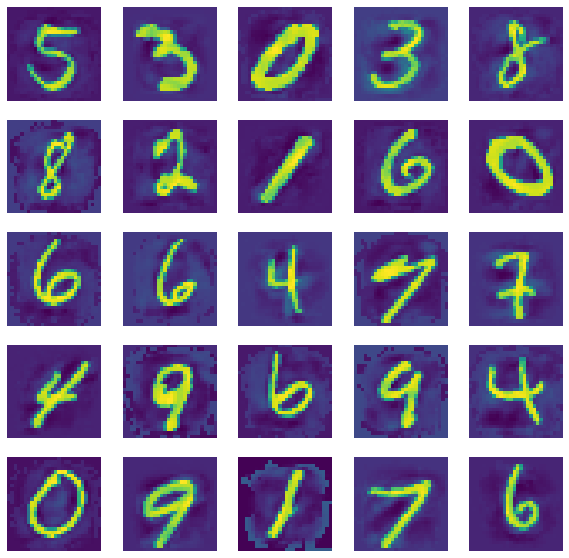

In [27]:
_, axs = plt.subplots(5, 5, figsize=(10, 10))
axs = axs.flatten()

c = model.layer0.centers.data.cpu().numpy().reshape(-1, 28,28)
imgs = c[:len(axs)]

for img, ax in zip(imgs, axs):
    ax.imshow(img)
    ax.set_axis_off()

plt.show()

#### Test for random image sample

In [28]:
with torch.no_grad():
    inputs = torch.rand(10, 28*28).to(device)*2-1
    xo = model.layer0(inputs)
    xo = model.scale_shift(xo)
    xo = model.softmax(xo).data

In [29]:
# xo.argmax(dim=1)
xo.max(dim=1)

torch.return_types.max(values=tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000]), indices=tensor([500, 500, 500, 500, 500, 500, 500, 500, 500, 500]))

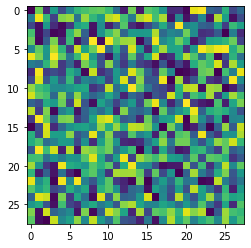

In [30]:
j=0
plt.imshow(inputs[j].reshape(28,28))

In [31]:
i = -1
nearest = torch.argsort(xo[j], descending=True)
nearest

tensor([500,  75,  44, 415, 261, 230, 118, 113,  37, 455, 168, 346,  49, 419,
         63,  94, 349, 259, 186, 197, 326, 139, 130, 355, 380, 399,  28, 150,
        464, 434, 377, 249,   3, 245, 119, 425, 418, 112, 402, 456, 360, 291,
        422, 187, 432,  21, 475, 381,  23, 110, 174, 359, 333, 416, 203, 298,
        301, 223, 488, 356, 279, 331, 428, 231,   1, 136, 127, 328, 482, 452,
        341, 225, 439, 466, 199, 151,  14,  15, 472, 284, 178, 162, 141, 304,
        243, 441, 156,  24, 221, 366, 404,  76, 433, 200, 180, 138, 497,   7,
         81, 250, 158, 329,  12,   9,  54, 335, 101, 214, 385, 287, 442, 184,
         69, 262, 410, 117, 353, 314, 100, 123, 246,  98, 145, 195, 351, 394,
         52,  10, 152, 248, 484,  74, 254, 345, 143, 309,  62, 147, 265, 202,
        163, 426,  26, 407,  18,  50, 216, 369, 272, 159, 102, 429, 459, 361,
         68, 103, 388, 481, 164, 412,  43,  55, 290, 278, 190,   2, 267, 133,
         40, 169, 436, 192,  56, 337,  73, 285, 224, 373, 435, 3

In [32]:
xo.shape

torch.Size([10, 501])

In [33]:
i+=1
print("prob:", xo[0][nearest[i]])
try:
    plt.imshow(model.layer0.centers.data[nearest[i]].reshape(28,28))
except:
    pass

prob: tensor(1.)


In [34]:
with torch.no_grad():
    xo_ = model.activ(xo)
    xo_ = model.layer1(xo_).data

In [35]:
xo_.argmax(dim=1)

tensor([8, 8, 8, 8, 8, 8, 8, 8, 8, 8])

In [36]:
#  model.layer1.weight[1], model.layer1.weight[10]

In [37]:
## scaling of softmax activation
torch.exp(model.activ.beta)

tensor([[1.2661, 1.0010, 1.1390, 0.9963, 1.0119, 1.1682, 1.0475, 1.0013, 1.0613,
         0.9695, 1.1061, 1.2879, 1.0019, 1.0460, 1.0009, 1.0001, 1.1974, 1.1421,
         1.0516, 1.0171, 1.0792, 0.9810, 1.2000, 1.0096, 1.0158, 1.1890, 1.0137,
         1.1722, 0.9956, 1.0510, 1.1316, 0.9528, 1.2054, 1.0129, 1.2779, 1.1699,
         1.3056, 0.9967, 1.1654, 1.0285, 1.2657, 1.0123, 1.0298, 1.1710, 0.9980,
         1.0088, 1.0989, 1.0129, 1.1460, 0.9954, 1.0278, 1.0489, 0.9717, 1.0195,
         1.0037, 1.1668, 1.2308, 1.0434, 1.0323, 1.0743, 1.0773, 1.0761, 0.9320,
         0.9991, 1.0478, 1.1474, 1.0023, 1.1490, 1.0450, 0.9891, 1.2262, 1.1287,
         1.0277, 1.0743, 0.9616, 0.9984, 0.9982, 1.2115, 1.0817, 1.0748, 1.2466,
         1.0065, 1.0599, 1.1648, 1.1137, 1.0879, 1.1487, 1.0184, 1.0289, 1.2383,
         0.9712, 1.0127, 1.0393, 1.1379, 0.9918, 1.0913, 1.2788, 1.1054, 1.0079,
         1.0030, 1.0548, 1.1837, 1.2113, 1.0199, 1.0771, 0.9784, 1.0095, 1.0194,
         1.2520, 1.0985, 0.9

In [38]:
imgs.min(), imgs.max()

(-1.5021473, 1.3647171)

In [39]:
model.layer1.weight.data[:,5]

tensor([-0.8496, -0.5598, -0.9144, -0.9858, -0.9081, -0.9638, -0.5954, -1.1517,
         2.1029, -1.0699, -0.1162])

## Adverserial Test

In [40]:
import foolbox as fb
import foolbox.attacks as fa

In [62]:
fmodel = fb.PyTorchModel(model.eval(), bounds=(-1, 1), device=device)

# attack = fa.LinfPGD()
attack = fa.FGSM()
# epsilons = [0.0, 0.001, 0.01, 0.03, 0.1, 0.3, 0.5, 1.0]

In [63]:
count = 0
failed = 0
rejected = 0
x_rejected = 0
for i, (xx, yy) in enumerate(tqdm(test_loader)):
    xx = xx.reshape(-1, 28*28)
    
    yout = model(xx)
    reject_out = yout.argmax(dim=1) == 10
    reject_hid = model.temp_maximum.max(dim=1)[1] == model.hidden_dim
    reject = torch.bitwise_or(reject_out, reject_hid)
    x_rejected += int(reject.type(torch.float32).sum())
    
    _, advs, success = attack(fmodel, xx, yy, epsilons=0.5)   
    yout = model(advs)
    reject_out = yout.argmax(dim=1) == 10
    reject_hid = model.temp_maximum.max(dim=1)[1] == model.hidden_dim
    reject = torch.bitwise_or(reject_out, reject_hid)
#     reject = reject_out
    rejected += int(reject.type(torch.float32).sum())
    
    fail = torch.bitwise_and(success, ~reject).type(torch.float32).sum()
#     fail = success.type(torch.float32).sum()
    failed += int(fail)    
    count += len(xx)

#     break

100%|██████████| 200/200 [00:04<00:00, 46.88it/s]


In [64]:
# success

In [65]:
count, failed, rejected, x_rejected

(10000, 2400, 6951, 1291)

In [66]:
(failed+x_rejected)/count

0.3691

In [46]:
# model.temp_maximum.max(dim=1)[1]

In [47]:
# yout.argmax(dim=1)

In [61]:
model.layer0.epsilon = 4.0

In [ ]:
"""
- epsilon can be changed to reject more and more inputs (including adverserial)
- Create Epsilon_hull and find how much test data lie inside
"""